# Forecast Tutorial

## Energy Load and Temperature from Gefcom2014

This notebook is designed to give a simple introduction to forecasting a two-dimensional time series using the Deep4Cast package. The time series data is borrowed from the [Gefcom2014](http://www.drhongtao.com/gefcom/2014) competition datasets, specifically, the simpler E subset of the data. It contains two related time series, one for energy load and one for temperature. The goal is to build a model that take both time series (and a few datetime features) into account when making forecasts.

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader

from deep4cast.forecasters import Forecaster
from deep4cast.models import WaveNet
from deep4cast.datasets import TimeSeriesDataset
import deep4cast.metrics as metrics

# Make RNG predictable
np.random.seed(0)
torch.manual_seed(0)

# Use a gpu if available, otherwise use cpu
device = ('cuda' if torch.cuda.is_available() else 'cpu')

%matplotlib inline

## Dataset
In this section we inspect the dataset, split it into a training and a test set, and prepare it for easy consuption with PyTorch-based data loaders. Model construction and training will be done in the next section.

### Loading and visualization
Before we do anything in research it is good practice to at least plot the data to get a feeling for what it is that we are trying to model. Since the dataset contains of only two time series we can simply plot them separately.

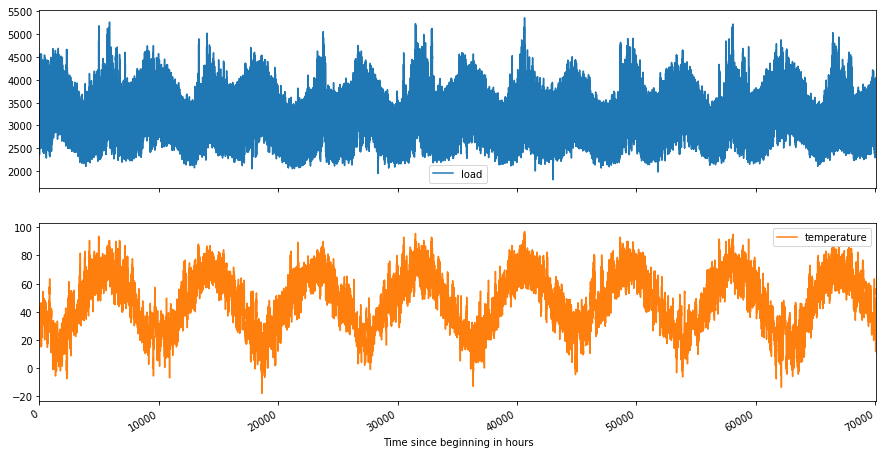

In [2]:
# Time to load the data from CSV
data= pd.read_csv('data/GEFCom2014-e.csv')
    
# Plot the data to help our imaginations
data[['load', 'temperature']].plot(subplots=True, figsize=(15, 8))
plt.xlabel('Time since beginning in hours')
plt.show()

### Divide into train and test
In order to train and evaluate our model, we need to divide the dataset into a train and a test dataset. After that, we process both datasets into a format that the forecaster can understand. Specifically, we use the DataLoader object from PyTorch to build batches.

However, we first need to specify how much history to use in creating a forecast of a given length:
- horizon = time steps to forecast
- lookback = time steps leading up to the period to be forecast

In [14]:
horizon = 720 #(in hours)
lookback = 1024 #(in hours)

In [4]:
# We can remove the datetime index and turn the dataframe into an array
data = data.set_index('time')
data_arr = data.values

# Get array into right shape (n_timeseries, n_variables, n_timesteps)
data_arr = np.expand_dims(data_arr.T, 0) 
data_train = list(data_arr[:,:,:-horizon])
data_test = list(data_arr[:,:,-horizon-lookback:])

We follow [Torchvision](https://pytorch.org/docs/stable/torchvision) in processing examples using [Transforms](https://pytorch.org/docs/stable/torchvision/transforms.html) chained together by [Compose](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Compose).

* `Tensorize` creates a tensor of the example.
* `LogTransform` natural logarithm of the targets after adding the offset (similar to [torch.log1p](https://pytorch.org/docs/stable/torch.html#torch.log1p)).
* `RemoveLast` subtracts the final value in the `lookback` from both `lookback` and `horizon`.
* `Target` specifies which index in the array to forecast.

We need to perform these transformations to have input features that are of the unit scale. If the input features are not of unit scale (i.e., of O(1)) for all features, the optimizer won't be able to find an optimium due to blow-ups in the gradient calculations.

In [5]:
transform = [
    {'Tensorize': None},
    {'LogTransform': {'targets': [0, -2], 'offset': 1.0}}, # Transform load data
    {'LogTransform': {'targets': [1 -1], 'offset': 10.0}}, # Transform temperature data
    {'RemoveLast': {'targets': [0, 1, -2, -1]}},
    {'Target': {'targets': [0, 1]}}
]

`TimeSeriesDataset` inherits from [Torch Datasets](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) for use with [Torch DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader). It handles the creation of the examples used to train the network using `lookback` and `horizon` to partition the time series.

The variable 'step' controls how far apart consective windowed samples from a time series
are spaced apart. For example, for a time series of length 100 and a setup with lookback 24 and horizon 12, we split the original time series into smaller training examples of length 24+12=36. How much these examples are overlapping is controlled by the parameter `step` in `TimeSeriesDataset`.

In [6]:
# Create a training and testing dataset. 
data_train = TimeSeriesDataset(
    data_train, 
    lookback, 
    horizon, 
    step=horizon,
    transform=transform
)
data_test = TimeSeriesDataset(
    data_test, 
    lookback, 
    horizon, 
    step=horizon, 
    transform=transform
)

# Create mini-batch data loader for batch training
dataloader_train = DataLoader(
    data_train, 
    batch_size=32, 
    shuffle=True, # Shuffle example during training
    pin_memory=True, # For optimizing GPU memory usage
    num_workers=1
)
dataloader_test = DataLoader(
    data_test, 
    batch_size=1, 
    shuffle=False
)

## Modeling and Forecasting

### Temporal Convolutions
The network architecture used here is based on ideas related to [WaveNet](https://deepmind.com/blog/wavenet-generative-model-raw-audio/). We employ the same architecture with a few modifications (e.g., a fully connected output layer for vector forecasts). It turns out that we do not need many layers in this example to achieve state-of-the-art results, most likely because of the simple autoregressive nature of the data.

In many ways, a temporal convoluational architecture is among the simplest possible architecures that we could employ using neural networks. In our approach, every layer has the same number of convolutional filters and uses residual connections.

When it comes to loss functions, we use the log-likelihood of probability distributions from the `torch.distributions` module. This mean that if one supplues a normal distribution the likelihood of the transformed data is modeled as coming from a normal distribution.

In [7]:
# Define the model architecture
n_layers = 10
model = WaveNet(input_channels=48,
                output_channels=2,
                horizon=horizon, 
                n_layers=n_layers)

# Define the optimizer
optim = torch.optim.Adam(model.parameters(), lr=0.001)

# Define the loss function
loss = torch.distributions.Normal

# Let's print out some important infos about the model architecure.
print('Number of model parameters: {}.'.format(model.n_parameters))
print('Receptive field size: {}.'.format(model.receptive_field_size))

Number of model parameters: 360270.
Receptive field size: 1024.


In [8]:
# Fit the forecaster
forecaster = Forecaster(model, loss, optim, n_epochs=10, device=device)
forecaster.fit(dataloader_train, eval_model=True)

Number of model parameters being fitted: 360270.
Epoch 1/10 [94/94 (67%)]	Loss: 60.622749	Elapsed/Remaining: 0m1s/0m8s   
Training error: 8.16e+04.
Epoch 2/10 [94/94 (67%)]	Loss: 52.341663	Elapsed/Remaining: 0m2s/0m7s   
Training error: 7.82e+04.
Epoch 3/10 [94/94 (67%)]	Loss: 59.500191	Elapsed/Remaining: 0m3s/0m7s   
Training error: 7.31e+04.
Epoch 4/10 [94/94 (67%)]	Loss: 51.322186	Elapsed/Remaining: 0m4s/0m6s   
Training error: 6.39e+04.
Epoch 5/10 [94/94 (67%)]	Loss: 38.136887	Elapsed/Remaining: 0m5s/0m5s   
Training error: 5.45e+04.
Epoch 6/10 [94/94 (67%)]	Loss: 34.152081	Elapsed/Remaining: 0m6s/0m4s   
Training error: 4.33e+04.
Epoch 7/10 [94/94 (67%)]	Loss: 25.147242	Elapsed/Remaining: 0m7s/0m3s   
Training error: 3.07e+04.
Epoch 8/10 [94/94 (67%)]	Loss: 21.447016	Elapsed/Remaining: 0m8s/0m2s   
Training error: 2.19e+04.
Epoch 9/10 [94/94 (67%)]	Loss: 13.807021	Elapsed/Remaining: 0m9s/0m1s   
Training error: 1.61e+04.
Epoch 10/10 [94/94 (67%)]	Loss: 8.742069	Elapsed/Remaining: 

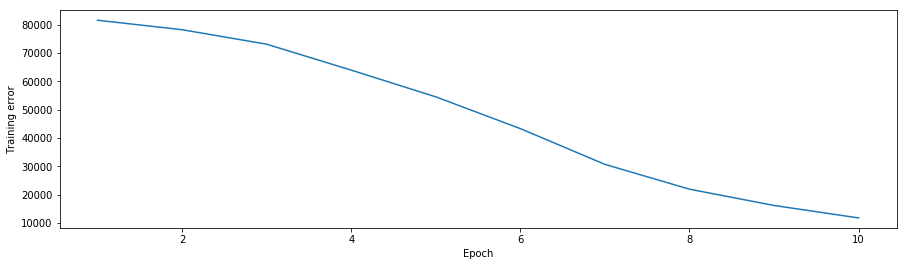

In [9]:
# Let's plot the training error
plt.figure(figsize=(15, 4))
plt.plot(range(1, forecaster.n_epochs+1), forecaster.history['training'])
plt.xlabel('Epoch')
plt.ylabel('Training error')
plt.show()

## Evaluation
Before any evaluation score can be calculated, we need to transform the output forecasts. The output from the foracaster is of the form (n_samples, n_time_series, n_variables, n_timesteps).
This means, that a point forcast needs to be calculated from the samples, for example, by taking the mean or the median.

In [10]:
# Get time series of actuals for the testing period
y_test = []
for example in dataloader_test:
    example = data_test.uncompose(example)
    y_test.append(example['y'])
y_test = np.concatenate(y_test)

# Get corresponding predictions by sampling from the approximate posterior 
# predicitve distribuyiuon
y_samples = forecaster.predict(dataloader_test, n_samples=100)

# Median forcast and 90% confidence intervals
y_fc = np.median(y_samples, axis=0)
y_fc_lq = np.percentile(y_samples, q=5, axis=0)
y_fc_uq = np.percentile(y_samples, q=95, axis=0)

We calculate the [symmetric MAPE](https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error) and [pinball loss](https://www.lokad.com/pinball-loss-function-definition), as well as the empirical coverage for the test set data.

sMAPE: [83.136475]%
Pinball loss: inf


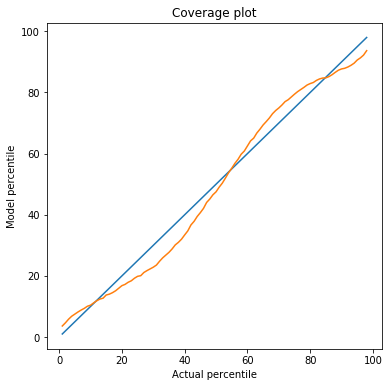

In [12]:
# Evaluate forecasts
smape = metrics.smape(y_samples, y_test)
perc = np.arange(1, 99)
coverage = metrics.coverage(y_samples, y_test, percentiles=perc)
pinball = metrics.pinball_loss(y_samples, y_test, percentiles=perc)

print('sMAPE: {}%'.format(smape))
print('Pinball loss: {}'.format(pinball))

plt.figure(figsize=(6, 6))
plt.plot(perc, perc)
plt.plot(perc, coverage)
plt.xlabel('Actual percentile')
plt.ylabel('Model percentile')
plt.title('Coverage plot')
plt.show()

Let's have a closer look at what a forecast looks like. We can use the model output to graph the mean, 95th and 5th percentiles. We'll also graph the actuals for comparison.

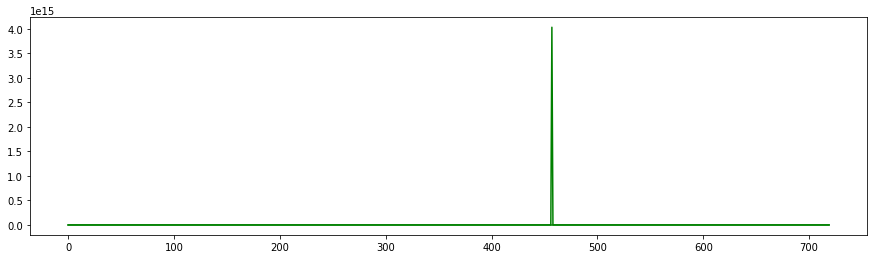

In [13]:
# Investigate forecasted load and conficdence
plt.figure(figsize=(15, 4))

#plt.plot(y_test[0].T, 'k-')
plt.plot(y_fc[0].T, 'g-')
#plt.plot(y_test_uq[0].T, 'g--', alpha=0.25)
#plt.plot(y_test_lq[0].T, 'g--', alpha=0.25)

#plt.ylim([0, 0.4e6])
#plt.xlim([0, y_test.shape[-1]])

#plt.ylabel('DAU')
plt.show()

This was a short introduction to forecasting with Deep4Cast using simple neural
network architectures and loss distributions.